In [1]:
import cv2 as cv
import numpy as np
from matplotlib import cm, pyplot as plt
from IPython.display import display, Markdown
import ipywidgets

from imageutils import pdf, discrete_uniform_noise, entropy, \
                       mutual_information, kl_divergence, parzen_filter, \
                       align_ranges

def dm(md):
    display(Markdown(md))

# For reproducible results
np.random.seed(0)

In [2]:
# Load image
I = cv.imread("img_retina.jpg", cv.IMREAD_GRAYSCALE)
# print("$H(I) = {:7.5f}$".format(entropy(pdf(I))))

## Mutual Information of $I$ and $I+N_A$

In [3]:
# Calculate mutual information
A = list(range(0, 205, 5))
MIA = [mutual_information(I, I + na)
       for na in (discrete_uniform_noise(I, a) for a in A)]

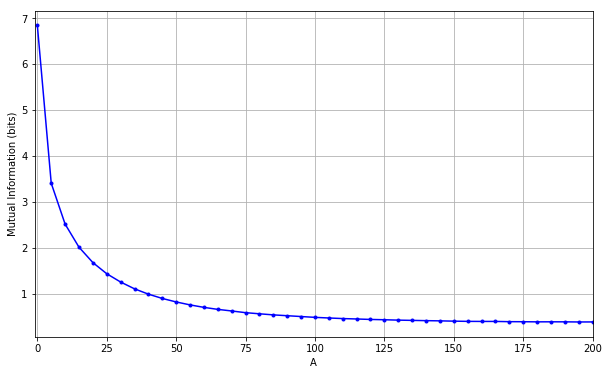

In [41]:
# Plot mutual information
_ = plt.figure(figsize=(10,6))
_ = plt.plot(A, MIA, 'b.-')
_ = plt.xlabel("A")
_ = plt.xlim(min(A)-1, max(A))
_ = plt.ylabel("Mutual Information (bits)")
_ = plt.grid()
_ = plt.show()

The mutual information between the original image $I$ and the image with noise added $I+N_A$ decreases as the noise level increases. For noise level of $A=0$, $I+N_A = I$ and the mutual information is equal to the entropy of the original image:

$$MI(I;I+N_0) = MI(I;I) = H(I)$$

In [34]:
N20 = discrete_uniform_noise(I, 20)
IN20 = I + N20

# Calculate entropies and mutual information for A = 20
print("Calculating:")
dm("#### Calculating:")

H_I_IN20 = entropy(pdf(I, IN20))
print("H(I, I+N20) = {:7.5f}$".format(H_I_IN20))
dm("$H(I, I+N_{{20}}) = {:7.5f}$".format(H_I_IN20))

H_I = entropy(pdf(I))
print("H(I) = {:7.5f}".format(H_I))
dm("$H(I) = {:7.5f}$".format(H_I))

H_IN20 = entropy(pdf(IN20))
print("H(I+N20) = {:7.5f}".format(H_IN20))
dm("$H(I+N_{{20}}) = {:7.5f}$".format(H_IN20))

MI_I_IN20 = mutual_information(I, IN20)
print("MI(I;I+N20) = {:7.5f}".format(MI_I_IN20))
dm("$MI(I;I+N_{{20}}) = {:7.5f}$".format(MI_I_IN20))

# Verify that joint entropy is equal to sum of independent
# entropies minus mutual information
print("Verifying:")
dm("#### Verifying:")
print("H(I, I+N20) = H(I) + H(I+N20) - MI(I;I+N20)")
print("{:7.5f} = {:7.5f} + {:7.5f} - {:7.5f}".format(H_I_IN20, H_I, H_IN20, MI_I_IN20))
print("{:7.5f} = {:7.5f}".format(H_I_IN20, H_I + H_IN20 - MI_I_IN20))

dm("$H(I, I+N_{{20}}) = H(I) + H(I+N_{{20}}) - MI(I;I+N_{{20}})$")
dm("${:7.5f} = {:7.5f} + {:7.5f} - {:7.5f}$".format(H_I_IN20, H_I, H_IN20, MI_I_IN20))
dm("${:7.5f} = {:7.5f}$".format(H_I_IN20, H_I + H_IN20 - MI_I_IN20))

Calculating:


#### Calculating:

H(I, I+N20) = 12.18229$


$H(I, I+N_{20}) = 12.18229$

H(I) = 6.84712


$H(I) = 6.84712$

H(I+N20) = 7.01523


$H(I+N_{20}) = 7.01523$

MI(I;I+N20) = 1.68006


$MI(I;I+N_{20}) = 1.68006$

Verifying:


#### Verifying:

H(I, I+N20) = H(I) + H(I+N20) - MI(I;I+N20)
12.18229 = 6.84712 + 7.01523 - 1.68006
12.18229 = 12.18229


$H(I, I+N_{{20}}) = H(I) + H(I+N_{{20}}) - MI(I;I+N_{{20}})$

$12.18229 = 6.84712 + 7.01523 - 1.68006$

$12.18229 = 12.18229$

## KL-Divergence of $I$ and $N$

In [6]:
N = np.random.randint(0, 256, I.shape)
# _ = plt.figure(figsize=(12,6))
# _ = plt.subplot(121)
# _ = plt.title('I')
# _ = plt.imshow(I, cmap=cm.gray)
# _ = plt.subplot(122)
# _ = plt.title('N = U[0,255]')
# _ = plt.imshow(N, cmap=cm.gray)
# _ = plt.show

In [7]:
N.min(), N.max()

(0, 255)

In [24]:
# Calculate KL divergences
pdf_I = pdf(I)
pdf_N = pdf(N)

KL_IN = kl_divergence(pdf_I, pdf_N)
KL_NI = kl_divergence(pdf_N, pdf_I)
for labels, kl in (("IN", KL_IN), ("NI", KL_NI)):
    dm("$D_{{KL}}({}\|{}) = {}$".format(labels[0], labels[1],
                                        "\infty" if kl == np.Infinity else kl))

$D_{KL}(I\|N) = 1.151468894390097$

$D_{KL}(N\|I) = \infty$



The reason $D_{{KL}}(N\|I) = \infty$ is that there are some pixel values which are present in $N$ but not present in the image $I$. In particular, there appear to be zero-counts for pixel values in $I$ near the extremes of the [0,255] range (see below).

On the other hand, the inverse is not true: every pixel value in $I$ is also present in $N$, and therefore $D_{{KL}}(I\|N) \neq \infty$

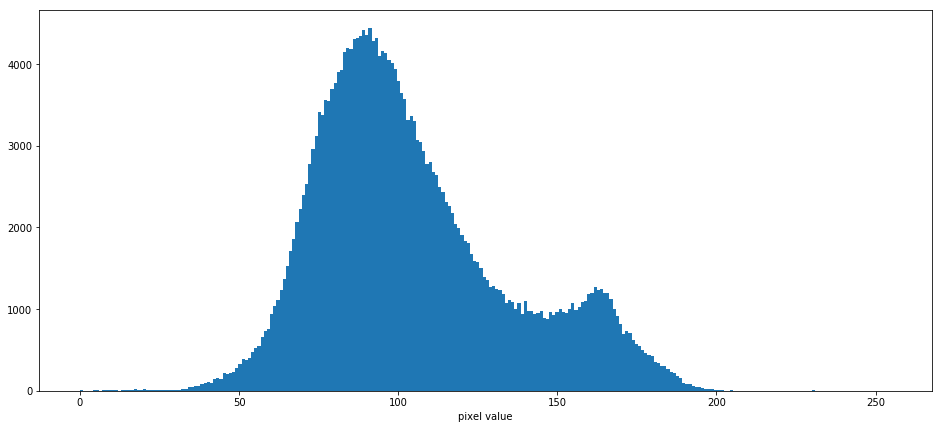

In [25]:
# _ = plt.figure(figsize=(16,7))
# _ = plt.hist(I.ravel(), bins=256)
# _ = plt.xlabel("Pixel intensity value")
# _ = plt.ylabel("Count")
# _ = plt.show()

In [27]:
# Verify KL calculations by comparing to official scipy implementation
import scipy.stats

# Test that the PDFs have the same bin range
assert np.array_equal(pdf_I[1], pdf_N[1])
print("Forward KL-divergence using scipy.stats.entropy")
print(scipy.stats.entropy(pdf_I[0], pdf_N[0], base=2))
print("Backward KL-divergence using scipy.stats.entropy")
print(scipy.stats.entropy(pdf_N[0], pdf_I[0], base=2))

Forward KL-divergence using scipy.stats.entropy
1.151468894390098
Backward KL-divergence using scipy.stats.entropy
inf


Good, scipy gives us the same values that we calculated independently.

## KL-Divergence of $I$ and $I+N_{20}$ Using Parzen Windows


In [20]:
for label, img in (("I", I), ("I+N_20", IN20)):
    print("{} has pixel values in the range [{}, {}]".format(label, img.min(), img.max()))

min_parzen_window = 1 + 2 * max(abs(I.max()-IN20.max()), abs(I.min()-IN20.min()))
print("Minimum Parzen window size of {} is necessary for non-infinite bidirectional KL-divergence".format(min_parzen_window))
dm("This implies a minimum Parzen window size of __{}__ for bidirectional KL-divergence $\\neq \\infty$".format(min_parzen_window))

I has pixel values in the range [0, 255]
I+N_20 has pixel values in the range [-17, 269]
Minimum Parzen window size of 35 is necessary for non-infinite bidirectional KL-divergence


This implies a minimum Parzen window size of __35__ for bidirectional KL-divergence $\neq \infty$

In [40]:
# Align the underlying ranges of the PDFs for the sake of Parzen
# filtering and KL-divergence calculations
pdf_I, pdf_IN20 = align_ranges(pdf(I), pdf(IN20))

#dm("Select a size for the symmetric Parzen window:")
#@ipywidgets.interact(window_size=(1, 2*min_parzen_window+1, 2), continuous_update=False)
def f(window_size=min_parzen_window):
    print("Using Parzen window of size:", window_size)
    
    # Apply Parzen filter to each PDF (i.e. convolve with Parzen window)
    parzen_I = parzen_filter(pdf_I, window_size)
    parzen_IN20 = parzen_filter(pdf_IN20, window_size)
    
    # Compute forward and backword KL-divergence
    KL_I_IN20_Parzen = kl_divergence(parzen_I, parzen_IN20)
    print("Forward KL-divergence Dkl(I|I+N20) = {:7.5f}".format(KL_I_IN20_Parzen))
    KL_IN20_I_Parzen = kl_divergence(parzen_IN20, parzen_I)
    print("Backward KL-divergence Dkl(I+N20|I) = {:7.5f}".format(KL_IN20_I_Parzen))

    # Display in markdown
    for labels, kl in ((("I","I+N_{{20}}"), KL_I_IN20_Parzen), 
                       (("I+N_{{20}}", "I"), KL_IN20_I_Parzen)):
        kl_str = "\infty" if kl == np.Infinity else "{:7.5f}".format(kl)
        dm("$D_{{KL}}({}\|{}) = {}$".format(labels[0], labels[1], kl_str))

f(35)

Using Parzen window of size: 35
Forward KL-divergence Dkl(I|I+N20) = 0.02636
Backward KL-divergence Dkl(I+N20|I) = 0.03133


$D_{KL}(I\|I+N_{{20}}) = 0.02636$

$D_{KL}(I+N_{{20}}\|I) = 0.03133$

Without Parzen windows (i.e. $window\_size = 1$), there are too many 0 values in the probability density functions, and the lack of overlap leads to division by zero and infinite KL-divergence.

For $window\_size < 9$, there are many 0 values in the probability density functions and the lack of consistently positive overlap in the densities leads to division by zero and infinite KL-divergence in both directions.

For $9 \le window\_size \lt 35$ there is positive overlap in the $I \to I+N_{20}$ direction but not in the $I+N_{20} \to I$ direction.

For $35 \le window\_size $, there is positive overlap between the PDFs in both directions and the KL-divergence $\neq \infty$ in both cases.